In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'parkjaeyoung' # username
os.environ['KAGGLE_KEY'] = '4c16bfdb89a9449e8972bbc76d2f95aa' # key

In [2]:
!kaggle datasets download -d datamunge/sign-language-mnist



  0%|          | 0.00/62.6M [00:00<?, ?B/s]
  2%|1         | 1.00M/62.6M [00:00<00:08, 7.85MB/s]
  5%|4         | 3.00M/62.6M [00:00<00:10, 6.24MB/s]
  8%|7         | 5.00M/62.6M [00:00<00:07, 8.15MB/s]
 11%|#1        | 7.00M/62.6M [00:00<00:06, 9.42MB/s]
 13%|#2        | 8.00M/62.6M [00:00<00:05, 9.65MB/s]
 14%|#4        | 9.00M/62.6M [00:01<00:07, 7.85MB/s]
 16%|#5        | 10.0M/62.6M [00:01<00:06, 8.36MB/s]
 19%|#9        | 12.0M/62.6M [00:01<00:05, 9.82MB/s]
 22%|##2       | 14.0M/62.6M [00:01<00:04, 10.2MB/s]
 26%|##5       | 16.0M/62.6M [00:01<00:04, 10.7MB/s]
 29%|##8       | 18.0M/62.6M [00:01<00:04, 11.3MB/s]
 32%|###1      | 20.0M/62.6M [00:02<00:03, 11.5MB/s]
 35%|###5      | 22.0M/62.6M [00:02<00:03, 11.3MB/s]
 38%|###8      | 24.0M/62.6M [00:02<00:03, 11.5MB/s]
 42%|####1     | 26.0M/62.6M [00:02<00:03, 11.8MB/s]
 45%|####4     | 28.0M/62.6M [00:02<00:03, 11.8MB/s]
 48%|####7     | 30.0M/62.6M [00:03<00:02, 11.8MB/s]
 51%|#####1    | 32.0M/62.6M [00:03<00:02, 11.6MB/s]
 

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [4]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [6]:
train_df.shape

(27455, 785)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


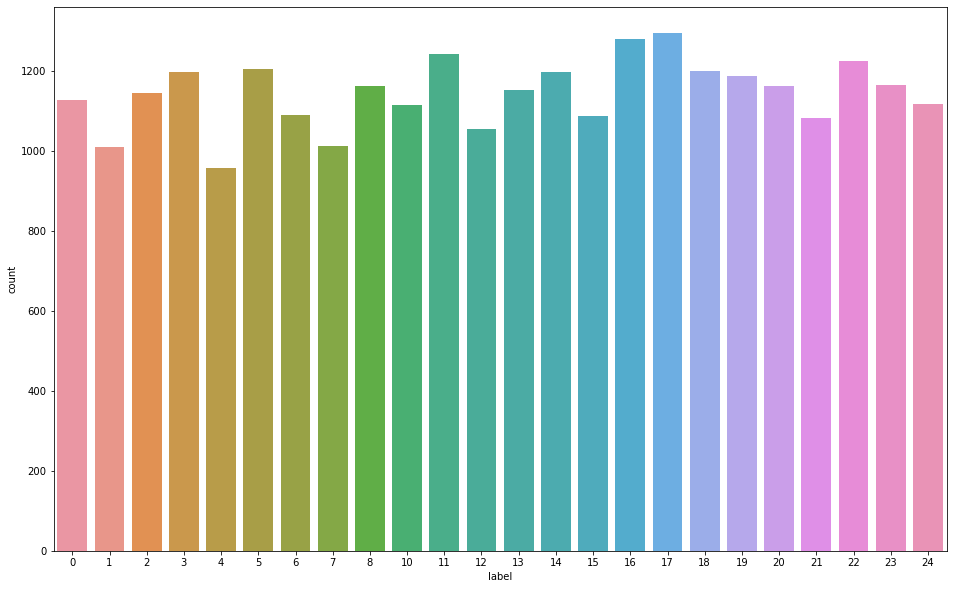

In [5]:
plt.figure(figsize=(16, 10))
sns.countplot(train_df['label'])
plt.show()

## 전처리 하기

In [8]:
train_df = train_df.astype(np.float32)
x_train = train_df.drop(columns=['label'], axis=1).values
x_train = x_train.reshape((-1, 28, 28, 1)) #3차원으로 만들어준다 
y_train = train_df[['label']].values

test_df = test_df.astype(np.float32)
x_test = test_df.drop(columns=['label'], axis=1).values
x_test = x_test.reshape((-1, 28, 28, 1))
y_test = test_df[['label']].values

In [10]:
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(27455, 28, 28, 1) (27455, 1)
(7172, 28, 28, 1) (7172, 1)


# 데이터 미리보기


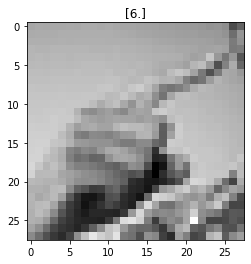

In [9]:
index = 1
plt.title(str(y_train[index]))
plt.imshow(x_train[index].reshape((28, 28)), cmap='gray')
plt.show()

# one-hot 인코딩


In [11]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

# 일반화
- 이미지 데이터는 픽셀리 0-255 사이의 정수(unsigned integer 8bit = uint8)로 되어 있다. 이것을 255로 나누어 0-1 사이의 소수점 데이터(floating point 32bit =float32)로 바꾸어 일반화를 시킨다 

- 이번에는 ImageDataGeneratior()를 사용하여 일반화를한다

In [18]:
train_image_datagen = ImageDataGenerator(
    rescale = 1./255, #일반화
)

train_datagen = train_image_datagen.flow(
    x = x_train,
    y = y_train,
    batch_size = 256,
    shuffle = True
)

test_image_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = test_image_datagen.flow(
    x = x_test,
    y = y_test,
    batch_size = 256,
    shuffle = False
)


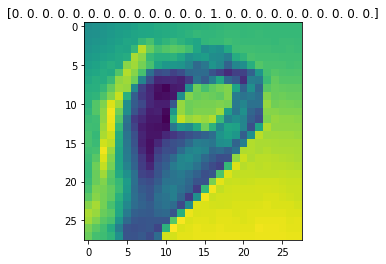

In [21]:
index = 1

preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

# 네트워크 구성


In [23]:
input = Input(shape = (28,28,1))

#kernel_size = 3 x 3 filters = 층 padding ='same' 인풋과 아웃풋을 같게해라
hidden = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(input)
hidden = MaxPooling2D(pool_size = 2, strides = 2)(hidden)

hidden = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(hidden)
hidden = MaxPooling2D(pool_size = 2, strides = 2)(hidden)

hidden = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(hidden)
hidden = MaxPooling2D(pool_size = 2, strides = 2)(hidden)

hidden = Flatten()(hidden)

hidden = Dense(512, activation = 'relu')(hidden)

hidden = Dropout(rate = 0.3)(hidden)

output = Dense(24, activation = 'softmax')(hidden)

model = Model(inputs = input, outputs = output)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics=['acc'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3211776   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)               

In [24]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 9s 88ms/step - loss: 1.9454 - acc: 0.4647 - val_loss: 1.0105 - val_acc: 0.7284
Epoch 2/20
108/108 [==============================] - 10s 89ms/step - loss: 0.5929 - acc: 0.8384 - val_loss: 0.6441 - val_acc: 0.8127
Epoch 3/20
108/108 [==============================] - 8s 71ms/step - loss: 0.2658 - acc: 0.9372 - val_loss: 0.5296 - val_acc: 0.8390
Epoch 4/20
108/108 [==============================] - 10s 89ms/step - loss: 0.1350 - acc: 0.9751 - val_loss: 0.4658 - val_acc: 0.8536
Epoch 5/20
108/108 [==============================] - 11s 98ms/step - loss: 0.0779 - acc: 0.9897 - val_loss: 0.4862 - val_acc: 0.8551
Epoch 6/20
108/108 [==============================] - 9s 79ms/step - loss: 0.0491 - acc: 0.9950 - val_loss: 0.4735 - val_acc: 0.8611
Epoch 7/20
108/108 [==============================] - 8s 75ms/step - loss: 0.0324 - acc: 0.9976 - val_loss: 0.4761 - val_acc: 0.8664
Epoch 8/20
108/108 [==============================] - 8s 77ms/step

# 학습 결과 그래프

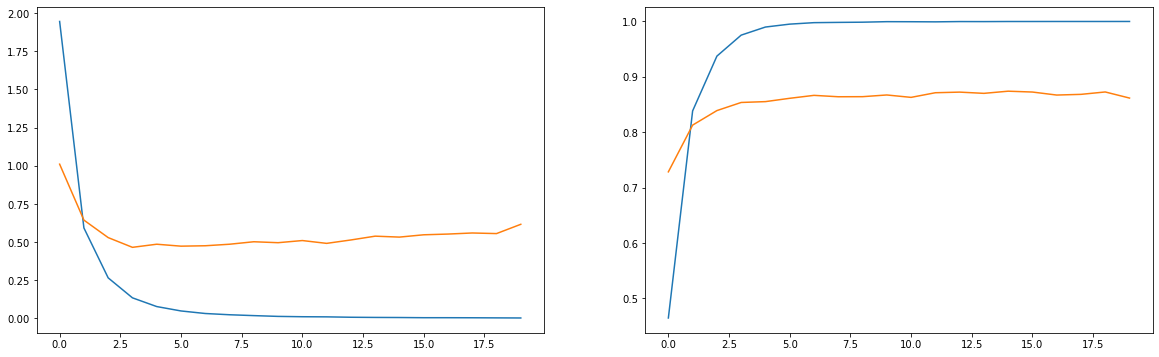

In [25]:
fig , axes = plt.subplots(1,2, figsize = (20,6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 이미지 증강방법


In [26]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10,  # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
)

train_datagen = train_image_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=256,
    shuffle=True
)
# 검증할때 는 변화를 안주어도된다 
test_image_datagen = ImageDataGenerator(
  rescale=1./255
)

test_datagen = test_image_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=256,
    shuffle=False
)

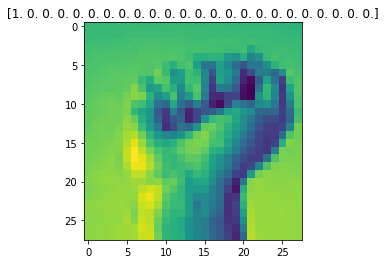

In [27]:
index = 1

preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

In [28]:
input = Input(shape=(28, 28, 1))

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden)

hidden = Dense(512, activation='relu')(hidden)

hidden = Dropout(rate=0.3)(hidden)

output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 32)         

In [29]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 15s 142ms/step - loss: 2.6635 - acc: 0.2019 - val_loss: 1.7078 - val_acc: 0.4667
Epoch 2/20
108/108 [==============================] - 18s 163ms/step - loss: 1.4953 - acc: 0.5147 - val_loss: 0.8800 - val_acc: 0.7510
Epoch 3/20
108/108 [==============================] - 19s 175ms/step - loss: 0.9656 - acc: 0.6800 - val_loss: 0.5676 - val_acc: 0.8115
Epoch 4/20
108/108 [==============================] - 16s 146ms/step - loss: 0.6557 - acc: 0.7830 - val_loss: 0.3528 - val_acc: 0.8871
Epoch 5/20
108/108 [==============================] - 16s 144ms/step - loss: 0.4813 - acc: 0.8425 - val_loss: 0.2328 - val_acc: 0.9279
Epoch 6/20
108/108 [==============================] - 14s 129ms/step - loss: 0.3647 - acc: 0.8793 - val_loss: 0.1985 - val_acc: 0.9352
Epoch 7/20
108/108 [==============================] - 13s 125ms/step - loss: 0.2878 - acc: 0.9043 - val_loss: 0.1288 - val_acc: 0.9625
Epoch 8/20
108/108 [==============================] - 1